In [ ]:
# Reference: https://github.com/songyouwei/ABSA-PyTorch

In [1]:
!pip install numpy==1.20.2
!pip install torch==1.4.0
!pip install sklearn
!pip install transformers

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

URL = '/content/gdrive/MyDrive/CSC413/'

Mounted at /content/gdrive


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.autograd import Variable
# from layers.dynamic_rnn import DynamicLSTM
# from layers.squeeze_embedding import SqueezeEmbedding
# from layers.attention import Attention, NoQueryAttention
# from layers.point_wise_feed_forward import PositionwiseFeedForward

from sklearn import metrics
# from time import strftime, localtime

from transformers import BertModel

# import torch
import torch.nn as nn


In [16]:
import logging
import argparse
import math
import os
import sys
import random
import matplotlib.pyplot as plt

In [5]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertModel, get_linear_schedule_with_warmup
from transformers import InputExample, InputFeatures

bert_model = BertModel.from_pretrained("bert-base-uncased", return_dict=False)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [6]:
df = pd.read_csv(URL + 'train_100000.csv',  encoding = "ISO-8859-1", 
                 names=["class", "id", "date", "query", "user", "text"])
# Make train, valid and test sets
df = df.drop(0)
df['class'] = df['class']/4
df_train, df_test = train_test_split(
  df,
  test_size=0.3,
  # random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  # random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((70000, 6), (15000, 6), (15000, 6))

In [ ]:
sample_txt = "@Naz I can't believe you would do that to me!"
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32, # Most tweets have 10-15 words
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [7]:
class TwitterDataset(Dataset):

  def __init__(self, tweets, classes, tokenizer, max_len):
    self.tweets = tweets
    self.classes = classes
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    text = str(self.tweets[item])
    target = self.classes[item]

    encoding = tokenizer.encode_plus(
      text,
      max_length=self.max_len, 
      truncation=True,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',  # Return PyTorch tensors
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'target': torch.tensor(target, dtype=torch.long)
    }

In [8]:
max_len = 32 # Most tweets have 10-15 words, max is 47

train_dataset = TwitterDataset(
    tweets=df_train["text"].to_numpy(),
    classes=df_train["class"].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

val_dataset = TwitterDataset(
    tweets=df_val["text"].to_numpy(),
    classes=df_val["class"].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

test_dataset = TwitterDataset(
    tweets=df_test["text"].to_numpy(),
    classes=df_test["class"].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

In [9]:
class Attention(nn.Module):
    def __init__(self, embed_dim, hidden_dim=None, out_dim=None, n_head=1, score_function='dot_product', dropout=0):
        ''' Attention Mechanism
        :param embed_dim:
        :param hidden_dim:
        :param out_dim:
        :param n_head: num of head (Multi-Head Attention)
        :param score_function: scaled_dot_product / mlp (concat) / bi_linear (general dot)
        :return (?, q_len, out_dim,)
        '''
        super(Attention, self).__init__()
        if hidden_dim is None:
            hidden_dim = embed_dim // n_head
        if out_dim is None:
            out_dim = embed_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.n_head = n_head
        self.score_function = score_function
        self.w_k = nn.Linear(embed_dim, n_head * hidden_dim)
        self.w_q = nn.Linear(embed_dim, n_head * hidden_dim)
        self.proj = nn.Linear(n_head * hidden_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        if score_function == 'mlp':
            self.weight = nn.Parameter(torch.Tensor(hidden_dim*2))
        elif self.score_function == 'bi_linear':
            self.weight = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        else:  # dot_product / scaled_dot_product
            self.register_parameter('weight', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.hidden_dim)
        if self.weight is not None:
            self.weight.data.uniform_(-stdv, stdv)

    def forward(self, k, q):
        if len(q.shape) == 2:  # q_len missing
            q = torch.unsqueeze(q, dim=1)
        if len(k.shape) == 2:  # k_len missing
            k = torch.unsqueeze(k, dim=1)
        mb_size = k.shape[0]  # ?
        k_len = k.shape[1]
        q_len = q.shape[1]
        # k: (?, k_len, embed_dim,)
        # q: (?, q_len, embed_dim,)
        # kx: (n_head*?, k_len, hidden_dim)
        # qx: (n_head*?, q_len, hidden_dim)
        # score: (n_head*?, q_len, k_len,)
        # output: (?, q_len, out_dim,)
        kx = self.w_k(k).view(mb_size, k_len, self.n_head, self.hidden_dim)
        kx = kx.permute(2, 0, 1, 3).contiguous().view(-1, k_len, self.hidden_dim)
        qx = self.w_q(q).view(mb_size, q_len, self.n_head, self.hidden_dim)
        qx = qx.permute(2, 0, 1, 3).contiguous().view(-1, q_len, self.hidden_dim)
        if self.score_function == 'dot_product':
            kt = kx.permute(0, 2, 1)
            score = torch.bmm(qx, kt)
        elif self.score_function == 'scaled_dot_product':
            kt = kx.permute(0, 2, 1)
            qkt = torch.bmm(qx, kt)
            score = torch.div(qkt, math.sqrt(self.hidden_dim))
        elif self.score_function == 'mlp':
            kxx = torch.unsqueeze(kx, dim=1).expand(-1, q_len, -1, -1)
            qxx = torch.unsqueeze(qx, dim=2).expand(-1, -1, k_len, -1)
            kq = torch.cat((kxx, qxx), dim=-1)  # (n_head*?, q_len, k_len, hidden_dim*2)
            # kq = torch.unsqueeze(kx, dim=1) + torch.unsqueeze(qx, dim=2)
            score = torch.tanh(torch.matmul(kq, self.weight))
        elif self.score_function == 'bi_linear':
            qw = torch.matmul(qx, self.weight)
            kt = kx.permute(0, 2, 1)
            score = torch.bmm(qw, kt)
        else:
            raise RuntimeError('invalid score_function')
        score = F.softmax(score, dim=-1)
        output = torch.bmm(score, kx)  # (n_head*?, q_len, hidden_dim)
        output = torch.cat(torch.split(output, mb_size, dim=0), dim=-1)  # (?, q_len, n_head*hidden_dim)
        output = self.proj(output)  # (?, q_len, out_dim)
        output = self.dropout(output)
        return output, score

In [10]:
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''
    def __init__(self, d_hid, d_inner_hid=None, dropout=0):
        super(PositionwiseFeedForward, self).__init__()
        if d_inner_hid is None:
            d_inner_hid = d_hid
        self.w_1 = nn.Conv1d(d_hid, d_inner_hid, 1)  # position-wise
        self.w_2 = nn.Conv1d(d_inner_hid, d_hid, 1)  # position-wise
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.w_1(x.transpose(1, 2)))
        output = self.w_2(output).transpose(2, 1)
        output = self.dropout(output)
        return output

In [11]:
class AEN_BERT(nn.Module):
    def __init__(self, bert, opt):
        super(AEN_BERT, self).__init__()
        self.opt = opt
        self.bert = bert
        self.dropout = nn.Dropout(0.1) # default 0.5

        self.attn_k = Attention(768, out_dim = 300, n_head=8, score_function='mlp', dropout = 0.1)
        self.attn_q = Attention(768, out_dim = 300, n_head=8, score_function='mlp', dropout = 0.1)
        self.ffn_c = PositionwiseFeedForward(300, dropout=0.1)
        self.ffn_t = PositionwiseFeedForward(300, dropout=0.1)

        self.attn_s1 = Attention(300, n_head=8, score_function='mlp', dropout=0.1)

        self.dense = nn.Linear(600, 2)

    def forward(self, inputs):
        context = inputs
        context, _ = self.bert(context)
        context = self.dropout(context)

        hc, _ = self.attn_k(context, context)
        hc = self.ffn_c(hc)

        s1, _ = self.attn_s1(hc, hc)

        # print(context.shape[2], hc.shape, s1.shape)
        # torch.Size([32, 32, 768]) torch.Size([32, 32, 300]) torch.Size([32, 32, 300])

        hc_mean = torch.div(torch.sum(hc, dim=1), context.shape[2])
        s1_mean = torch.div(torch.sum(s1, dim=1), context.shape[2])

        x = torch.cat((hc_mean, s1_mean), dim=-1)
        out = self.dense(x)
        return out

In [13]:
class Instructor:
    def __init__(self, opt):
        self.opt = opt
        self.model = opt['model_class']

    def _train(self, criterion, optimizer, train_data_loader, val_data_loader):

        num_epochs = self.opt['epochs']

        t_loss, t_acc, v_loss, v_acc = [], [], [], []

        for epoch in range(num_epochs):
          print('epoch: {}'.format(epoch))
          n_correct, n_total, loss_total = 0, 0, 0
          self.model.train()

          for i_batch, batch in enumerate(train_data_loader):
            optimizer.zero_grad()

            inputs = batch["input_ids"].to(self.opt["device"])
            outputs = self.model(inputs)
            targets = batch["target"].to(self.opt["device"])

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            n_correct += (torch.argmax(outputs, -1) == targets).sum().item()
            n_total += len(outputs)
            loss_total += loss.item() * len(outputs)

          train_loss, train_acc = loss_total / n_total, n_correct / n_total
          val_acc, val_loss = self.evaluate(val_data_loader, criterion)
          print('loss: {:.4f}, acc: {:.4f}'.format(train_loss, train_acc))
          print('val_loss: {:.4f}, val_acc: {:.4f}'.format(val_loss, val_acc))

          t_loss.append(train_loss)
          t_acc.append(train_acc)
          v_loss.append(val_loss)
          v_acc.append(val_acc)

        return t_loss, t_acc, v_loss, v_acc

    def evaluate(self, data_loader, criterion):
        n_correct, n_total, total_loss = 0, 0, 0
        self.model.eval()

        with torch.no_grad():
            for i_batch, batch in enumerate(data_loader):
                inputs = batch["input_ids"].to(self.opt["device"])
                outputs = self.model(inputs)
                targets = batch["target"].to(self.opt["device"])

                loss = criterion(outputs, targets)
                n_correct += (torch.argmax(outputs, -1) == targets).sum().item()
                n_total += len(outputs)
                total_loss += loss

        acc = n_correct / n_total
        return acc, total_loss/n_total

    def run(self):
        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss().to(self.opt['device'])
        _params = filter(lambda p: p.requires_grad, self.model.parameters())
        
        optimizer = opt['optimizer']

        train_data_loader = DataLoader(train_dataset, batch_size=128)
        test_data_loader =  DataLoader(val_dataset, batch_size=128)
        val_data_loader = DataLoader(test_dataset, batch_size=128)

        # self._reset_params()
        t_loss, t_acc, v_loss, v_acc = self._train(criterion, optimizer, train_data_loader, val_data_loader)
        test_acc, test_loss = self.evaluate(test_data_loader, criterion)
        print('test_acc: {:.4f}, test_loss: {:.4f}'.format(test_acc, test_loss))
        return t_loss, t_acc, v_loss, v_acc

In [14]:
device = 'cuda'
opt = {}
model = AEN_BERT(bert_model, opt).to(device)
lr = 1e-5
epochs = 3
    
opt['epochs'] = epochs
opt['device'] = device
opt['model_class'] = model
opt['initializer'] = torch.nn.init.xavier_uniform_
opt['optimizer'] = torch.optim.Adam(model.parameters(), lr=lr)
    
ins = Instructor(opt)
t_loss, t_acc, v_loss, v_acc = ins.run()

epoch: 0
loss: 0.4800, acc: 0.7887
val_loss: 0.0030, val_acc: 0.8304
epoch: 1
loss: 0.3520, acc: 0.8463
val_loss: 0.0029, val_acc: 0.8358
epoch: 2
loss: 0.3032, acc: 0.8720
val_loss: 0.0030, val_acc: 0.8345
test_acc: 0.8389, test_loss: 0.0030


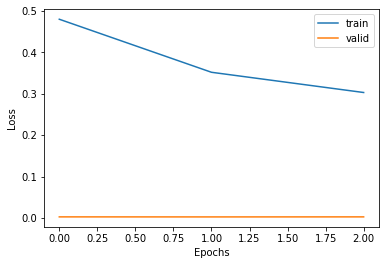

In [21]:
eps = range(epochs)


plt.plot(eps, t_loss, label="train")
plt.plot(eps, [0.0030, 0.0029, 0.0030], label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

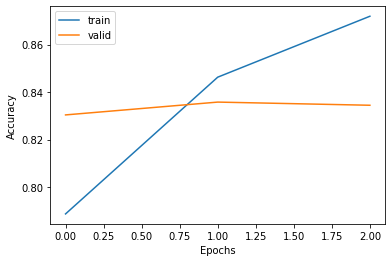

In [22]:
eps = range(epochs)

plt.plot(eps, t_acc, label="train")
plt.plot(eps, v_acc, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()